# Machine Learning Fundamentals - Lecture 06

This is the Jupyter notebook for Lecture 06 of the Machine Learning Fundamentals course.

In [1]:
# Import the required libraries using the commonly use short names (pd, sns, ...)
import numpy as np
import pandas as pd

# The Path object from pathlib allows us to easily build paths in an
# OS-independent fashion
from pathlib import Path

# Load the required scikit-learn classes and functions
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay


# Load matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

In [2]:
# Load the dataset (note the use of the Path object)
df = pd.read_csv(Path("..", "datasets", "Pokemon.csv"))

# It's not good practice to have column names with spaces and other non-standard
# characters, so let's fix this by renaming the columns to standard names
df.rename(columns={
    "Type 1" : "Type1",
    "Type 2" : "Type2",
    "Sp. Atk" : "SpAtk",
    "Sp. Def" : "SpDef",
}, inplace=True)

# Replace missing values in the "Type2" column with the string "None"
df["Type2"] = df["Type2"].fillna("None")

# Since primary and secondary types are essentially categories (and not just
# strings / objects), we can convert these columns to the category type
df["Type1"] = df["Type1"].astype("category")
df["Type2"] = df["Type2"].astype("category")

## 2D binary classification with scikit-learn

### Helper function for plotting

This function is inspired by this famous
[scikit-learn code](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
to compare classifiers. We adapt it to our own needs, making sure that the
background colors are directly related to $[0,1]$ probabilities (logistic
regression) or class regions (SVM), and that the decision boundary (and margins
in SVM) are clearly plotted.

In [3]:
# These colors are based on the mentioned scikit-learn code
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

# This function draws on a specified axis with the given classifier and data
def decision_sub_plot(ax, clf, X, X_train, X_test, y_train, y_test):

    # Define additional legend handles for the decision boundary lines, required
    # for both logistic regression and SVM
    new_lines = [ Line2D([0], [0], color="k", linestyle="-", label="Decision boundary") ]

    # Common parameters for the various DecisionBoundaryDisplay.from_estimator()
    # function calls
    common_params = {"estimator": clf, "X": X, "ax": ax}

    # We need to draw the background differently for logistic regression and SVM
    if isinstance(clf[-1], LogisticRegression):

        # For logistic regression, draw the background using class probabilities
        # This will give us good intuition on how these probabilities change
        # in the classification space
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict_proba",
            plot_method="contourf",
            cmap=cm,
            alpha=0.3,
            levels=np.linspace(0.0, 1.0, num=11), # 10 levels of probability between 0 and 1
        )

        # For logistic regression, we just draw the decision boundary
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="decision_function",
            plot_method="contour",
            levels=[0],
            colors="k",
            linestyles="-",
        )

    else:

        # For SVM, there are no direct probabilities, so we just draw the
        # background colors of each class region
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            cmap=cm,
            alpha=0.3,
        )

        # For SVM we draw not only the decision boundary, but also the margins
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="decision_function",
            plot_method="contour",
            levels=[-1, 0, 1],
            colors=["k", "k", "k"],
            linestyles=["--", "-", "--"],
        )

        # For SVM we'll also add a legend handle for the margin lines
        new_lines.append(Line2D([0], [0], color="k", linestyle="--", label="Margins"))

    # Plot the training points
    ax.scatter(
        X_train[~y_train, 0],
        X_train[~y_train, 1],
        c=cm_bright.colors[0],
        alpha=0.15,
        edgecolors="k",
        label="Non-legendary (train)",
    )
    ax.scatter(
        X_train[y_train, 0],
        X_train[y_train, 1],
        c=cm_bright.colors[1],
        alpha=0.15,
        edgecolors="k",
        label="Legendary (train)",
    )

    # Plot the testing points
    ax.scatter(
        X_test[~y_test, 0],
        X_test[~y_test, 1],
        c=cm_bright.colors[0],
        marker="d",
        edgecolors="k",
        label="Non-legendary (test)",
    )
    ax.scatter(
        X_test[y_test, 0],
        X_test[y_test, 1],
        c=cm_bright.colors[1],
        marker="d",
        edgecolors="k",
        label="Legendary (test)",
    )

    # Axis labels
    ax.set_xlabel("Attack")
    ax.set_ylabel("Speed")

    # Present the accuracy directly in the figure
    ax.text(
        0.95,
        0.05,  # (x, y) in axes fraction coordinates
        f"Acc = {clf.score(X_test, y_test):.3f}",
        transform=ax.transAxes,  # interpret (x, y) as fraction of Axes
        ha="right",
        va="bottom",  # align text to right bottom corner
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
    )

    # Add the decision boundary (and margin) legend handles to the current
    # legend handles (which refer to the training and test points)
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(new_lines)
    labels.extend([line.get_label() for line in new_lines])

    # Now stash these updated legend handles in the axes object into a
    # hacked instance variable called _pending_labels
    ax._pending_legend = (handles, labels)

### Preprocessing

In [4]:
# Let's use two numerical features
features = ["Attack", "Speed"]

# Get only the specified features
X = df[features].to_numpy()

# Our target values will the the "Legendary" column
y = df["Legendary"].to_numpy()

# Let's split our data into training (80%) and test (20%) sets
# Change the random_state parameter do split data in different ways
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic regression

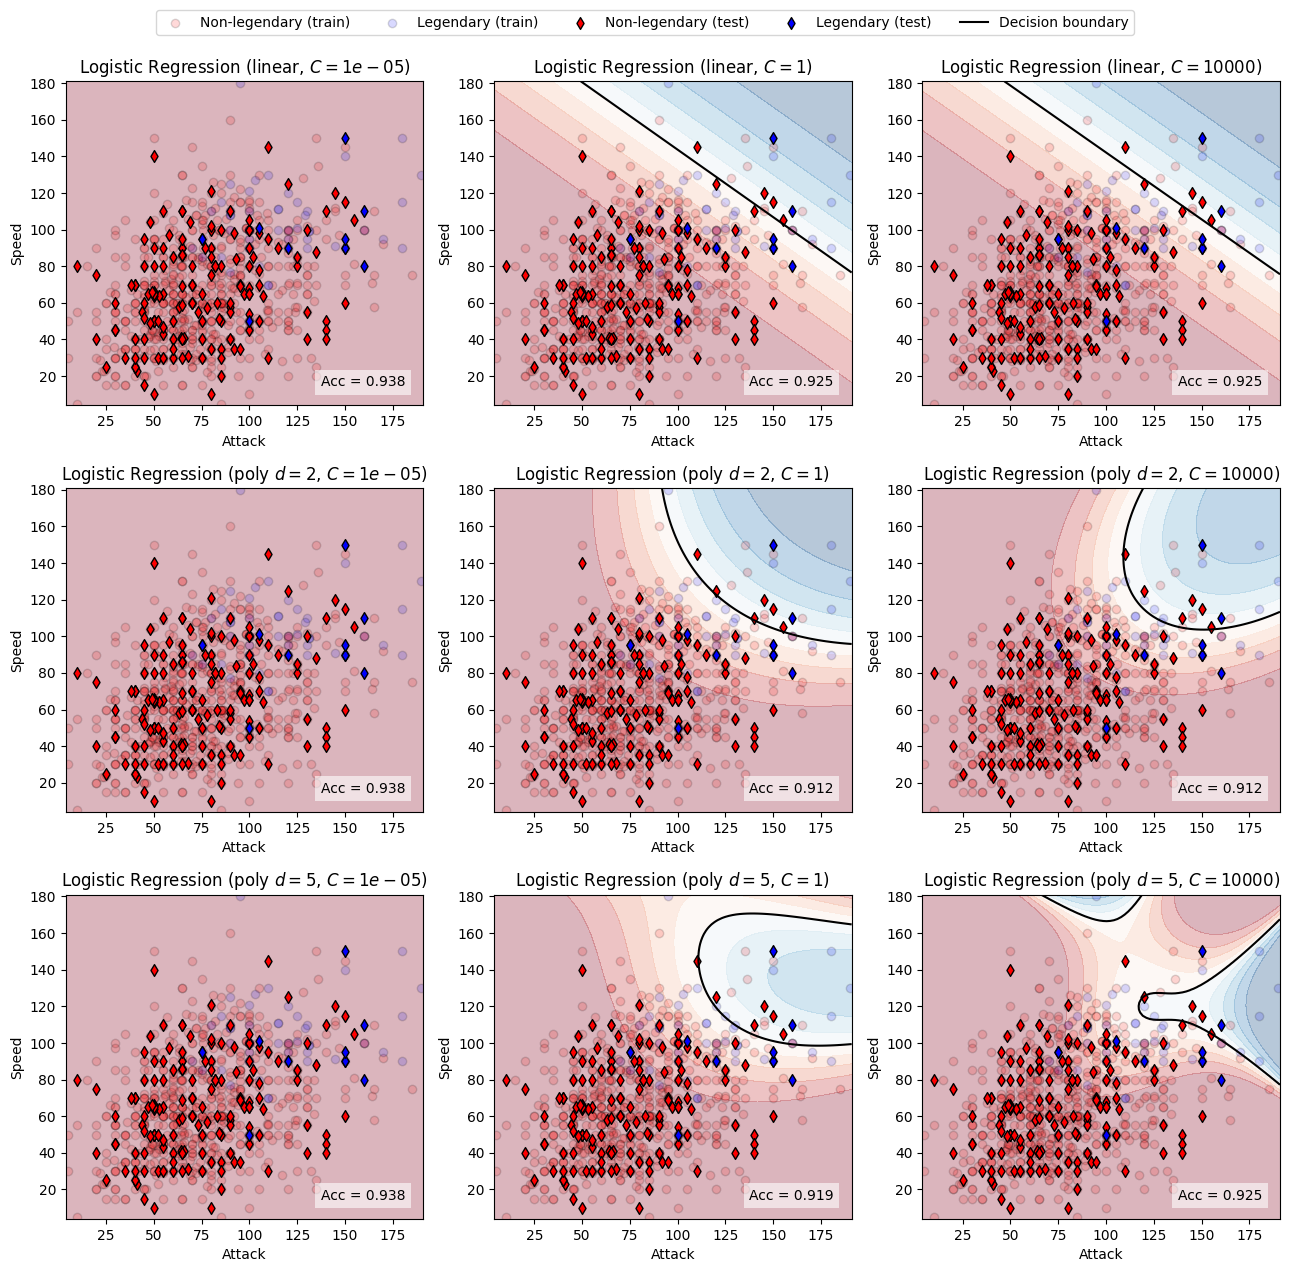

In [5]:
# Create the plot
fig, ax = plt.subplots(3, 3, figsize=(13, 13))

# Test different values of C and different polynomial degrees
for iC, C in enumerate((0.00001, 1, 10000)):
    for ipD, polyd in enumerate((1, 2, 5)):

        # Determine a subplot title for the current hyperparameter combination
        if polyd == 1:
            linpoly = "linear"
        else:
            linpoly = f"poly $d={polyd}$"

        title = f"Logistic Regression ({linpoly}, $C={C}$)"

        # Using the pipeline here makes things a lot simpler when it comes to
        # plotting
        clf = Pipeline(
            [
                ("poly", PolynomialFeatures(degree=polyd)),
                ("scale", StandardScaler()),
                ("clf", LogisticRegression(C=C)),
            ]
        )

        # Train the classifier
        clf.fit(X_train, y_train)

        # Select the subplot to draw on
        axc = ax[ipD, iC]

        # Call our function
        decision_sub_plot(axc, clf, X, X_train, X_test, y_train, y_test)

        # And place a title on the subplot
        axc.set_title(title)

# Add a single legend for all subplots using our little hack from the function
# in which we stashed the pending legend in an ad hoc instance variable
fig.legend(*ax[0, 0]._pending_legend, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 0.98))

# Adjust layout so legend fits nicely
fig.tight_layout(rect=(0, 0, 1, 0.95))

This figure shows us a lot of interesting results.

First, let's look at the case when $C=0.00001$ (leftmost column), which makes L2
regularization (the default in `LogisticRegression()`) very strong. Remember,
the general loss function for both logistic regression and SVM with L2
regularization is as follows:

$$
\text{LossWithRegularization} = \text{Loss} + \frac{1}{2C} ||\mathbf{w}||^2
$$

where $\mathbf{w}$ are the weights or coefficients of the decision line (in our
lectures we sometimes refer to these individually as $\mathbf{\beta_j}$). So,
very low $C$ makes regularization very strong, meaning the minimization process
will focus more on minimizing the coefficients $\mathbf{w}$, and less on
separating classes. Consequently, the model effectively learns no separation
between classes, so it defaults to predicting the majority class to minimize
overall loss. The majority class in this case is "Non-legendary", so that is the
class that is always predicted. This is a clear case of underfitting.

The next case is when $C=1.0$ (middle column), where regularization is balanced
with the base loss function of the model (a.k.a., empirical loss). In other
words, there's a balance between fitting the data and keeping weights small.
This is quite visible when polynomial features are used ($d=2$, $d=5$), forcing
the decision boundary to be smooth and soft, neither under- nor overfitted.

In the case of weak regularization (very large $C$), the penalty on large
weights is small. Thus, the optimizer focuses almost entirely on minimizing the
empirical loss (i.e., in better separating classes to get perfect training
accuracy). This can be seen in the right column of images, especially when using
polynomial features: the decision boundary is now more contorted to fit more
training points, especially outliers or rare examples. This may result in
overfitting, which is exactly the issue that regularization sets out to avoid.

Overall, we can see that accuracy is a very poor metric, especially in cases of
high class imbalance, such as the Pokémon dataset. For example, if we predict
all Pokémon as non-legendary, we'll have a "nice" high accuracy of 0.938, which
is not very helpful. Furthermore, intuitive fits, as those observed for $C=1.0$
with $d=2$ and $d=5$, do not result in higher accuracy. We'll discuss
alternative metrics in our next lecture.

For the multidimensional case, we'll keep using accuracy, but will use a feature
of scikit-learn that allows us to balance classes, therefore giving more meaning
to the observed accuracy.

### SVM

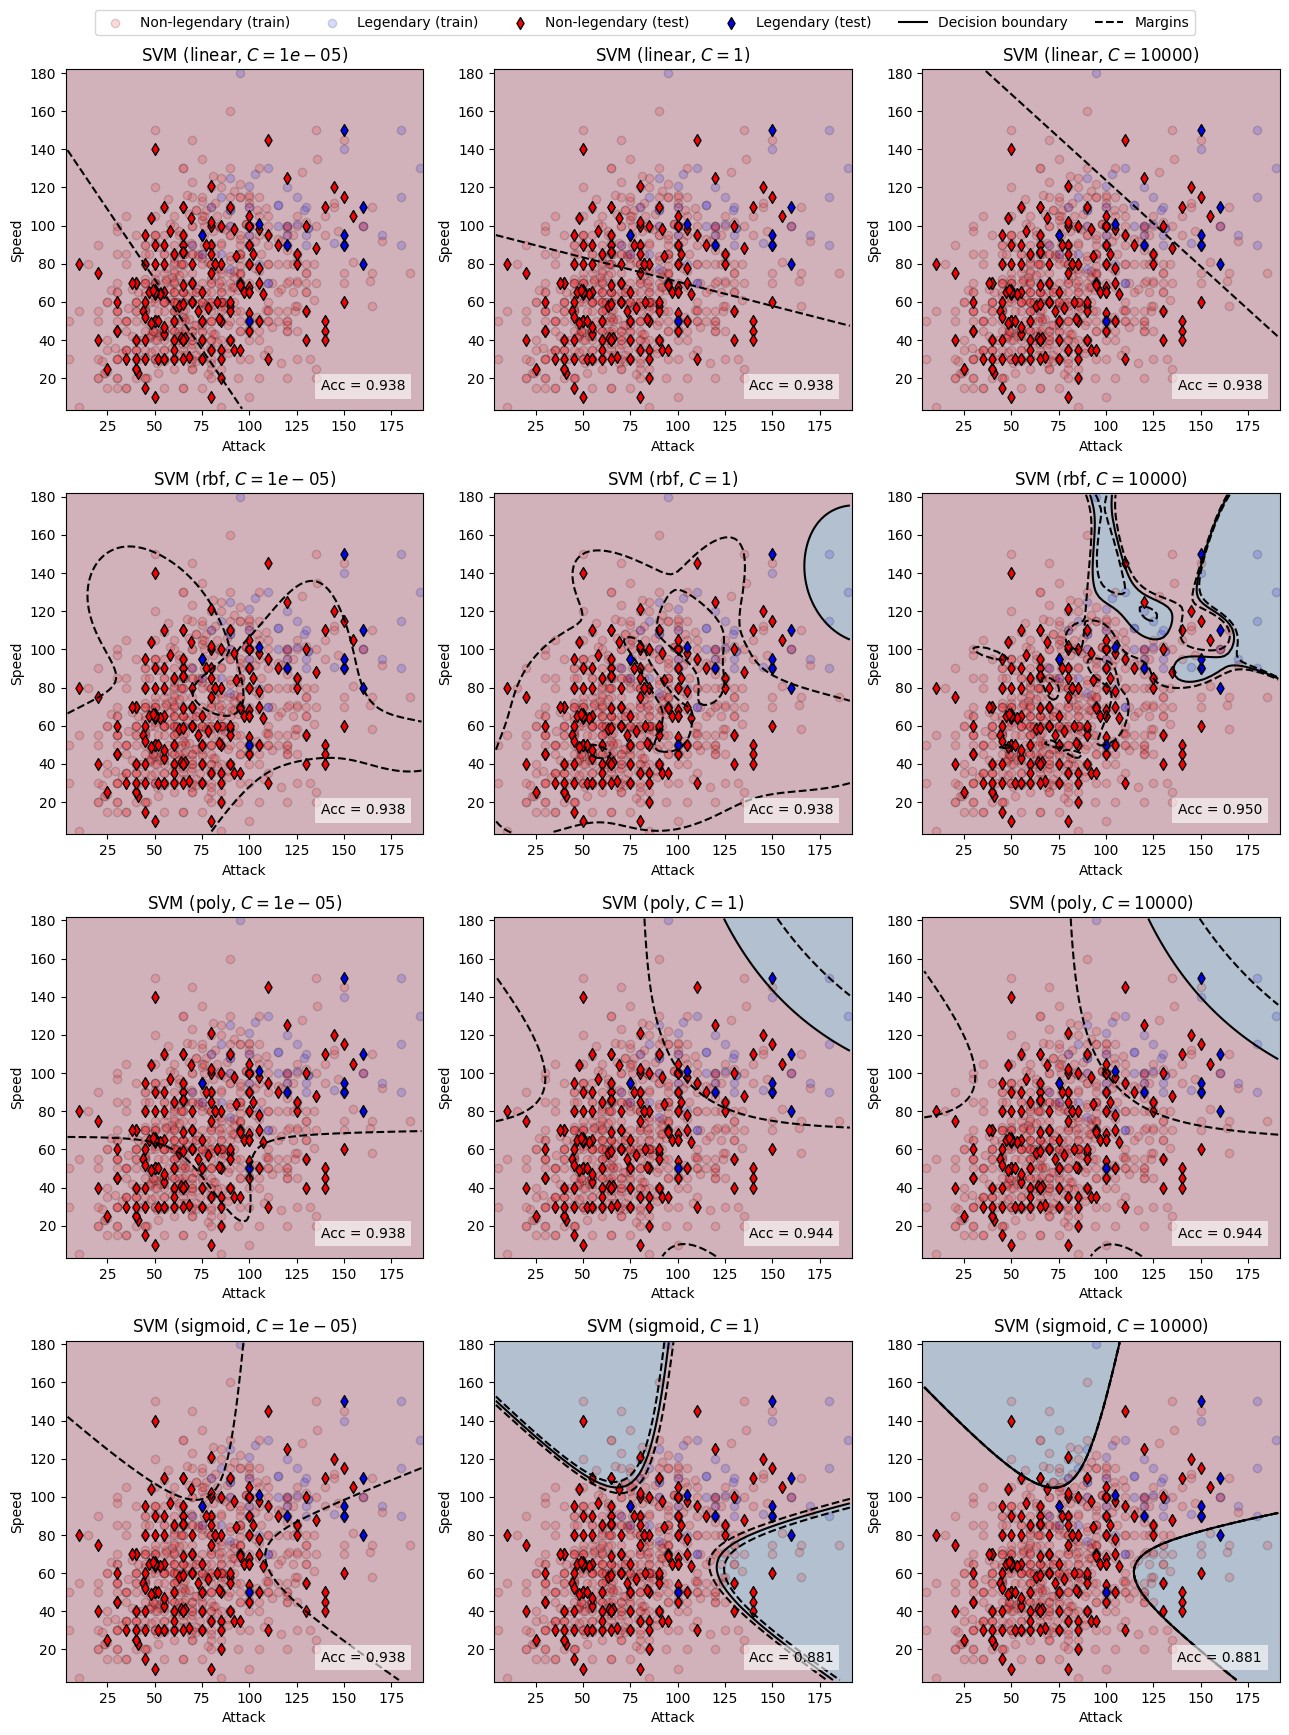

In [6]:
# Create the plot
fig, ax = plt.subplots(4, 3, figsize=(13, 18))

svms = {}

# Test different values of C and different kernels (with default values)
for iC, C in enumerate((0.00001, 1, 10000)):
    for ipK, kernel in enumerate(("linear", "rbf", "poly", "sigmoid")):

        # Determine a subplot title for the current hyperparameter combination
        title = f"SVM ({kernel}, $C={C}$)"

        # Using the pipeline here makes things a lot simpler when it comes to
        # plotting
        clf = Pipeline(
            [
                ("scale", StandardScaler()),
                ("clf", SVC(C=C, kernel=kernel, probability=True)),
            ]
        )

        # Train the classifier
        clf.fit(X_train, y_train)

        svms[title] = clf

        # Select the subplot to draw on
        axc = ax[ipK, iC]

        # Call our function
        decision_sub_plot(axc, clf, X, X_train, X_test, y_train, y_test)

        # And place a title on the subplot
        axc.set_title(title)

# Add a single legend for all subplots using our little hack from the function
# in which we stashed the pending legend in an ad hoc instance variable
fig.legend(*ax[0, 0]._pending_legend, loc="upper center", ncol=6, bbox_to_anchor=(0.5, 0.965))

# Adjust layout so legend fits nicely
fig.tight_layout(rect=(0, 0, 1, 0.95))

These results, for SVM, have several similarities with the ones from logistic
regression. For very high regularization (left column, $C=0.00001$), the model
generalizes too much and simply classifies all test examples as non-legendary
(which is the majority label). Interestingly, some margins can be observed, but
the decision boundary is too far away to make any difference. Remember: large
margins can make the model underfit, which is the case here.

Moving from the left column to the right, as the regularization influence
diminishes, it is possible to observe the margins being reduced (they
practically disappear in the bottom right image for the sigmoid kernel with
$C=10000$, being essentially merged with the decision boundary). For the linear
kernel (top row), although the margin is reduced and moves toward a more
intuitive separation of classes, it is not enough for the model to actually
perform any different. For the RBF kernel (second row), beyond the margins
getting smaller for larger $C$, we can also observe that the decision boundary
becomes increasingly more contorted, which can lead to overfitting. In any case,
the RBF kernel with $C=10000$ (rightmost image in the second row), shows the
highest test set accuracy of the experiment so far: $0.95$. For the polynomial
and sigmoid kernels, increasing $C$ (reducing regularization) does not
meaningfully change classification, as the actual decision boundaries barely
change (although the margins change a bit more). But why does this happen? The
effect of regularization in SVMs (through $C$) is strongest in linear and RBF
kernels because their flexibility directly depends on $C$: linear models are
simple, so $C$ clearly dictates margin width, and RBF models are very flexible,
so $C$ strongly governs overfitting. In contrast, polynomial and sigmoid kernels
have built-in biases (i.e., polynomial degree and sigmoid saturation) which
dominate model behavior, making changes in $C$ less visually or practically
impactful.

## $n$-D binary classification with scikit-learn

Due to the issues observed with class imbalance in the 2D case, we'll use the
parameter `class_weight="balanced"` in both classifiers for this $n$-dimensional
experiment. This will use the values of `y` to automatically adjust weights
inversely proportional to class frequencies in the input data. In other words,
it will allow the rarer "Legendary" Pokémons to have the same classification
weight as the much more common "Non-legendary" ones, making the accuracy score
more intuitive and interpretable.

### Preprocessing

In [7]:
# Let's use all numerical features
features = ["HP", "Attack", "Defense", "SpAtk", "SpDef", "Speed"]

# Get only the specified features
X = df[features].to_numpy()

# Our target values will the the "Legendary" column
y = df["Legendary"].to_numpy()

# Let's split our data into training (80%) and test (20%) sets
# Change the random_state parameter do split data in different ways
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic regression

In [9]:
# List we're well put the accuracies (we'll transform it into a dataframe latter)
lr_acc = []

# Test different values of C and different polynomial degrees
for C in (0.001, 0.01, 0.1, 1, 10, 100, 1000):
    for polyd in (1, 2, 5, 20):

        # Determine a dataframe column name for the current hyperparameter combination
        if polyd == 1:
            linpoly = "linear"
        else:
            linpoly = f"poly d={polyd:2d}"

        # Let's keep using the pipeline
        # Note the class_weight="balanced" parameter, to give equal weight to
        # rare legendary labels (and also max_iter=1500, which the default
        # solver requires to fit the model)
        clf = Pipeline(
            [
                ("poly", PolynomialFeatures(degree=polyd)),
                ("scale", StandardScaler()),
                ("clf", LogisticRegression(C=C, max_iter=1500, class_weight="balanced")),
            ]
        )

        # Train the classifier
        clf.fit(X_train, y_train)

        # Keep the hyperparameters and the respective calculated accuracy
        lr_acc.append([linpoly, C, clf.score(X_test, y_test)])

# Convert our results list into a dataframe
df_lr_acc = pd.DataFrame(lr_acc, columns=["degree", "C", "accuracy"])

# Show accuracy results by combining C (rows) and polynomial degree (columns)
df_lr_acc.pivot(index="C", columns="degree", values="accuracy")

degree,linear,poly d= 2,poly d= 5,poly d=20
C,,,,
0.001,0.84375,0.90000,0.93125,0.93750
0.010,0.88125,0.91250,0.93750,0.93125
0.100,0.90625,0.92500,0.93750,0.93750
1.000,0.92500,0.93125,0.93750,0.93125
10.000,0.93125,0.93750,0.93750,0.94375
100.000,0.93125,0.93750,0.93125,0.94375
1000.000,0.93125,0.92500,0.92500,0.95000


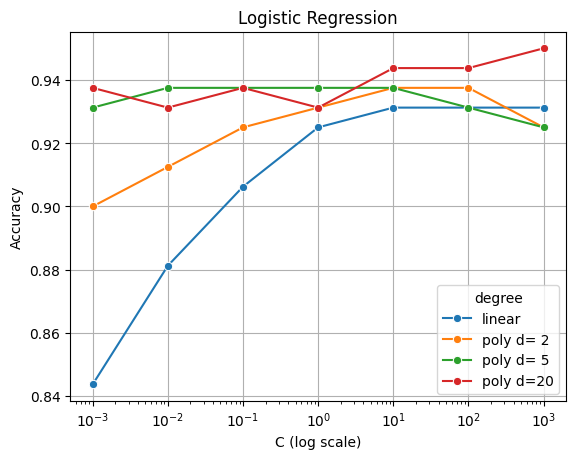

In [16]:
# Let's plot these results (note the logarithmic scale of C)
ax = sns.lineplot(data=df_lr_acc, x="C", y="accuracy", hue="degree", marker="o")
ax.set_xscale("log")
ax.set_xlabel("C (log scale)")
ax.set_ylabel("Accuracy")
ax.set_title("Logistic Regression")
ax.grid(True)

Let's analyse these results.

First, setting `class_weight="balanced"` clearly affects accuracy when the rare
"legendary" labels are misslabeled. We never got accuracies below $0.912$ in the
2D case with logistic regression, and here, with more features to help
classification, we're looking at accuracies down to $0.84$.

Second, these lower accuracies occur for linear and polynomial $d=2$, where the
model's flexibility is more limited, so strong regularization (small $C$) overly
constrains the coefficients, leading to underfitting and lower accuracy. As $C$
increases (weaker regularization), the model can fit the data better and
accuracy rises.

In contrast, high-degree polynomials ($d=5$ and $d=20$) are already very
flexible: they can model complex boundaries even when regularized quite a bit.
So, changing $C$ doesn't alter their performance much: they're expressive enough
to reach a similar accuracy across a wide range of $C$ values. In short:

- Linear or low degree polynomials: accuracy is more sensitive to $C$
  (regularization limits fitting power).
- High-degree polynomials: accuracy relatively flat vs. $C$ (already flexible,
  regularization less critical).

## SVM

In [11]:
# List we're well put the accuracies (we'll transform it into a dataframe latter)
svc_acc = []

# Test different values of C and different kernels
for C in (0.001, 0.01, 0.1, 1, 10, 100, 1000):
    for kernel in ("linear", "rbf", "poly", "sigmoid"):

        # Let's keep using the pipeline
        # Note the class_weight="balanced" parameter, to give equal weight to
        # rare legendary labels
        clf = Pipeline(
            [
                ("scale", StandardScaler()),
                ("clf", SVC(C=C, kernel=kernel, class_weight="balanced")),
            ]
        )

        # Train the classifier
        clf.fit(X_train, y_train)

        # Keep the hyperparameters and the respective calculated accuracy
        svc_acc.append([kernel, C, clf.score(X_test, y_test)])

# Convert our results list into a dataframe
df_svc_acc = pd.DataFrame(svc_acc, columns=["kernel", "C", "accuracy"])

# Show accuracy results by combining C (rows) and kernels (columns)
df_svc_acc.pivot(index="C", columns="kernel", values="accuracy")

kernel,linear,poly,rbf,sigmoid
C,,,,
0.001,0.77500,0.96250,0.06250,0.06250
0.010,0.85625,0.94375,0.79375,0.56250
0.100,0.91875,0.92500,0.88125,0.70625
1.000,0.92500,0.93125,0.93750,0.68750
10.000,0.92500,0.92500,0.94375,0.68125
100.000,0.92500,0.91875,0.92500,0.73750
1000.000,0.92500,0.93125,0.91875,0.73750


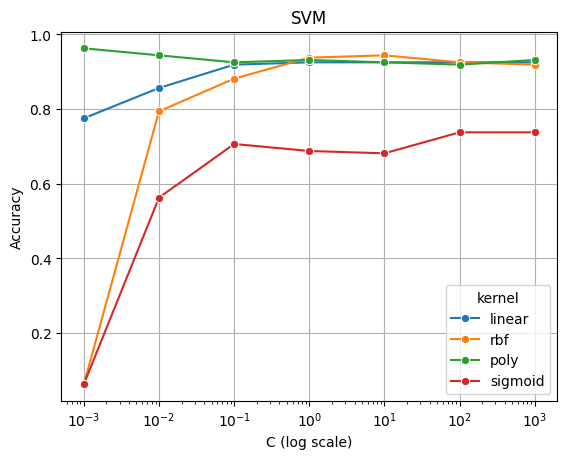

In [17]:
# Let's plot these results (note the logarithmic scale of C)
ax = sns.lineplot(data=df_svc_acc, x="C", y="accuracy", hue="kernel", marker="o")
ax.set_xscale("log")
ax.set_xlabel("C (log scale)")
ax.set_ylabel("Accuracy")
ax.set_title("SVM")
ax.grid(True)

Let's analyse the SVM results:


First, accuracy for the **linear kernel** rises with $C$ and then plateaus. This
happens because small $C$ (strong regularization) enforces a wide margin that
underfits, while larger $C$ allows a tighter fit until performance stabilizes
once the margin is appropriate.

Second, the **RBF kernel** is clearly very sensitive to small $C$, heavily
underfitting, but once $C$ increases, it fits the data well and accuracy
quickly saturates near the top.

Third, like in the case of Logistic Regression before, **polynomial kernels**
are already quite flexible. Performance is high even with strong regularization,
so changes in $C$ barely affect accuracy.

Fourth, the **sigmoid kernel** generally performs less consistently and often
worse, as already observed in the 2D case. Its behavior with $C$ tends to be
erratic and less reliable.

Finally, we're observing much worse accuracies in some cases with SVM that we
didn't observe with logistic regression. This happens because with very low $C$,
SVMs allow many training misclassifications to keep the margin large, which can
make nonlinear kernels (RBF, sigmoid) produce almost flat or meaningless
decision boundaries. Logistic regression, on the other hand, still fits
probabilities smoothly even under strong regularization, so its accuracy doesn't
drop as dramatically.